# Principal Component Analysis of FAA Flight Data

Given operational data for 74 airports over a 10 year period, I conducted a principal component analysis to examine underlying factors impacting flight delays. The data contains durations of gate, taxiing, and total delays for both arrivals and departures, volume of arrivals, departures, cancellations, and diversions, as well as the percent of flights that were delayed arriving or departing.


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

/Users/teresaborcuch/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
cancellations = pd.read_csv("../assets/airport_cancellations.csv")
airports = pd.read_csv("../assets/airports.csv")
operations = pd.read_csv("../assets/Airport_operations.csv")

In [3]:
# merge the datasets
data = operations.merge(airports, left_on = "airport", right_on = "LocID", how = "left")

In [4]:
data.shape

(841, 28)

In [5]:
data = data.merge(cancellations, left_on = ["airport","year"], right_on = ['Airport','Year'], how = "inner")

In [6]:
data.head()

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,...,AP Type,Latitude,Longitude,Boundary Data Available,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,...,Federalized/Commercial,35.040194,-106.609194,Yes,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,...,Federalized/Commercial,35.040194,-106.609194,Yes,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,...,Federalized/Commercial,35.040194,-106.609194,Yes,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,...,Federalized/Commercial,35.040194,-106.609194,Yes,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,...,Federalized/Commercial,35.040194,-106.609194,Yes,ABQ,2008.0,333.0,300.0,79.0,42.0


# Exploratory Data Analysis

These data seem deceptively straightforward. Longer delays mean fewer on-time flights, right? There's a bit more to it. First, I want to differentiate between how frequently an airport has a late flight (the percent on-time columns for arrivals and departures), and how late it is (the average delay columns). Having every flight arrive one minute late may not have the same effect as having 5% of the flights arrive 1 hour late.

It's also important to understand how each variable is defined. [This website](http://aspmhelp.faa.gov/index.php/ASPM_Airport_Analysis:_Definitions_of_Variables) provides the definitions of the Aviation System Performance Metrics. One distinction that needs to be made is that all of the average delay times only include delays > 1 minute, so a flight that is on time is not included. Therefore, the average delays are not truly averaged across all flights. It's more accurate to think of them as the average delay, when there is a delay. 

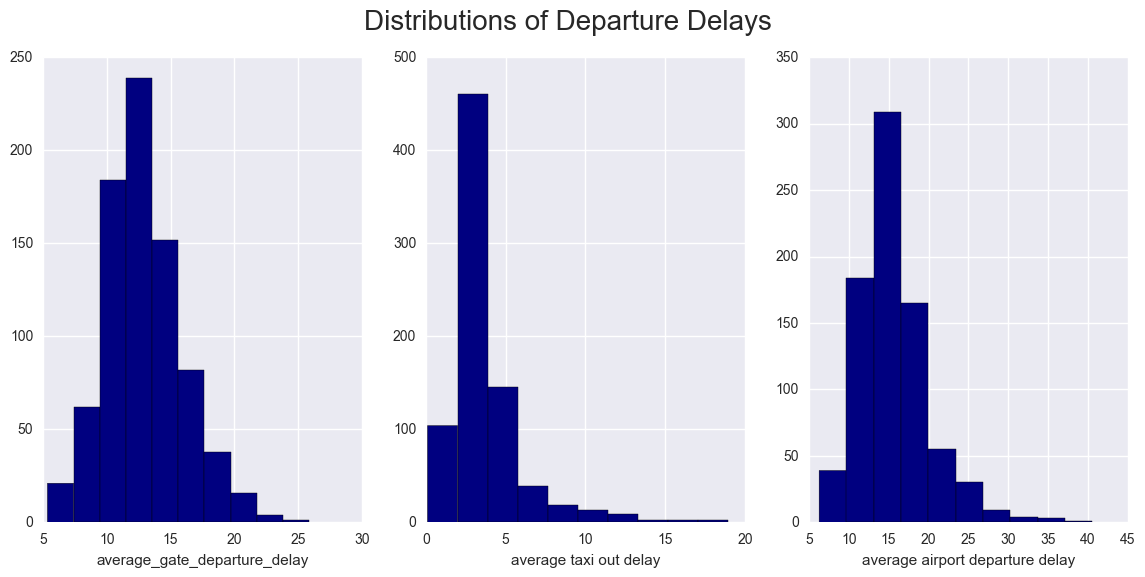

In [91]:
# plot histograms for departure delays
fig = plt.figure(figsize = (14,6))
count = 1
for col in ['average_gate_departure_delay','average taxi out delay','average airport departure delay']:
    ax = fig.add_subplot(1,3,count)
    ax.hist(data[col], color = "navy")
    ax.set_xlabel(col)
    count +=1
fig.suptitle('Distributions of Departure Delays', fontsize = 20)
plt.show()
fig.tight_layout()
    

From these plots, I can see that the average flight is delayed  around 12 minutes at the gate, and only about 3 minutes in taxi-ing out. It seems that the majority of the total average departure delay comes from sitting at the gate rather than slow taxi-ing out.

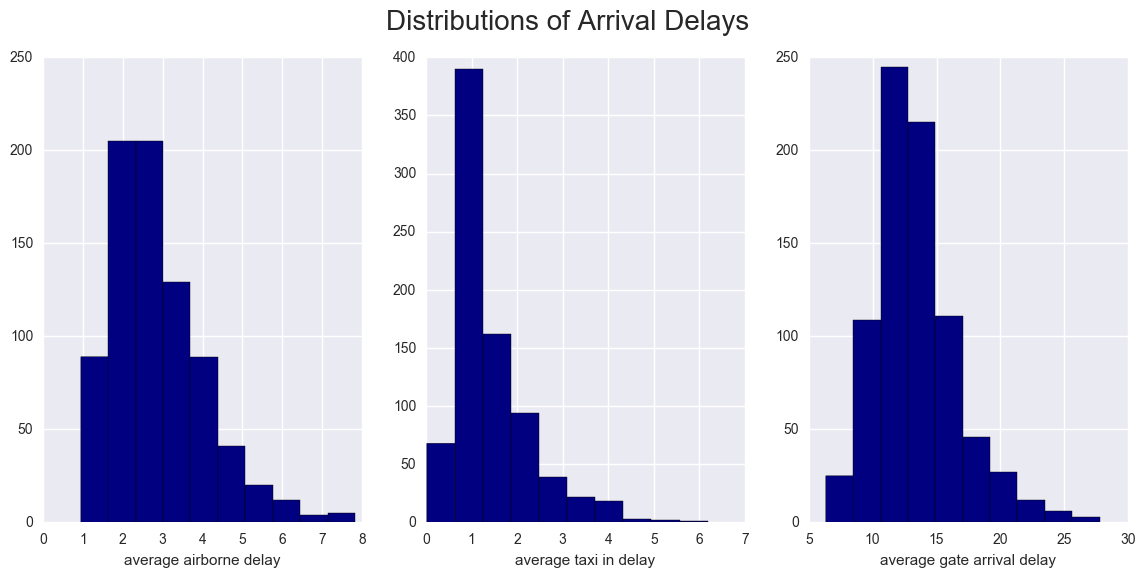

In [92]:
# plot histograms for arrival delays
fig = plt.figure(figsize = (14,6))
count = 1
for col in ['average airborne delay', 'average taxi in delay','average gate arrival delay']:
    ax = fig.add_subplot(1,3,count)
    ax.hist(data[col], color = "navy")
    ax.set_xlabel(col)
    count +=1
fig.suptitle('Distributions of Arrival Delays', fontsize = 20)
plt.show()
fig.tight_layout()

From these histograms, I can see the average airborne and taxi-in delays are between 2-3 and 1-2 minutes respectively, but the average gate arrival delay is significantly longer, between 10-15 minutes. Average gate arrival is defined as the difference between scheduled and actual arrival times, and I hypothesize that this difference between average gate arrival delay and the other arrival delays actually spills over from departure delays.

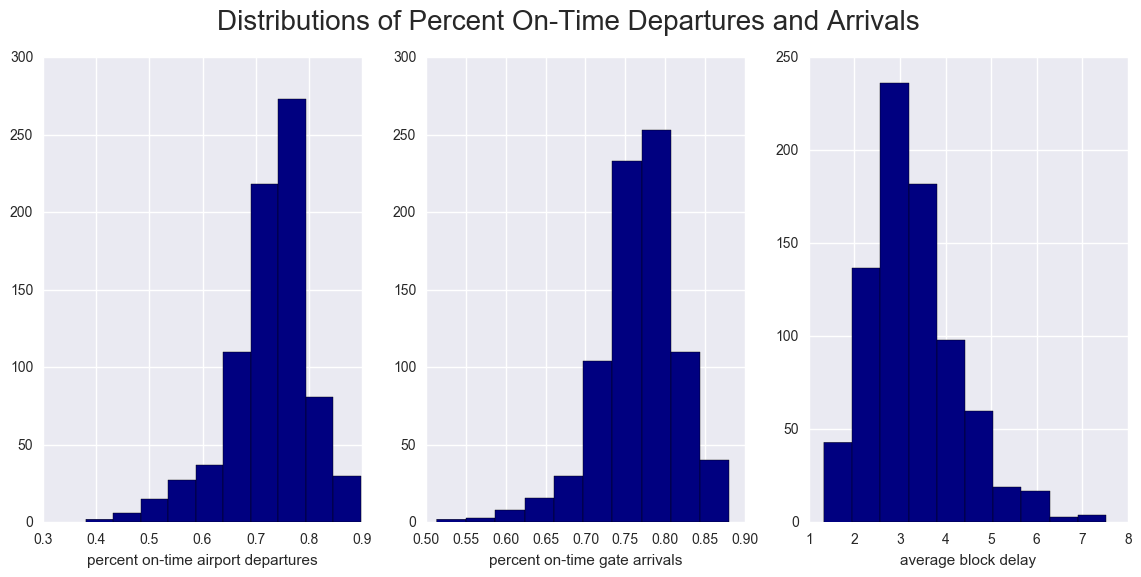

In [93]:
# plot histograms for on time departures and arrivals
fig = plt.figure(figsize = (14,6))
count = 1
for col in ['percent on-time airport departures', 'percent on-time gate arrivals', 'average block delay']:
    ax = fig.add_subplot(1,3,count)
    ax.hist(data[col], color = "navy")
    ax.set_xlabel(col)
    count +=1
fig.suptitle('Distributions of Percent On-Time Departures and Arrivals', fontsize = 20)
plt.show()
fig.tight_layout()



Here, I can see that in fact, most flights do depart and arrive on time. The majority of airports had between 70 and 80% of their flights leave and arrive on time. Average block delay is difference in minutes between scheduled and actual gate-to-gate time. The fact that this is lower than the average departure and arrival times may be explained by the fact that it includes on-time flights, and possibly flights that arrive early.

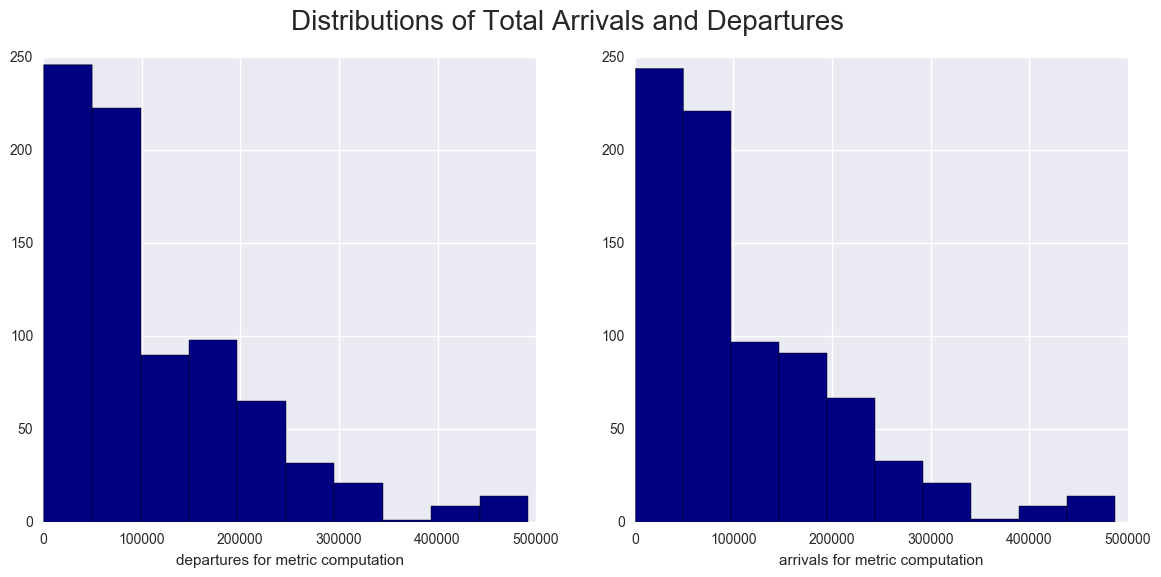

In [94]:
# plot histograms for on time departures and arrivals
fig = plt.figure(figsize = (14,6))
count = 1
for col in ['departures for metric computation', 'arrivals for metric computation']:
    ax = fig.add_subplot(1,2,count)
    ax.hist(data[col], color = "navy")
    ax.set_xlabel(col)
    count +=1
fig.suptitle('Distributions of Total Arrivals and Departures', fontsize = 20)
plt.show()
fig.tight_layout()



The arrival and departure data are heavily left skewed. The majority of airports had fewer than 100,000 flights pass through in a given year, but there are a few that had over 400,000 flights.

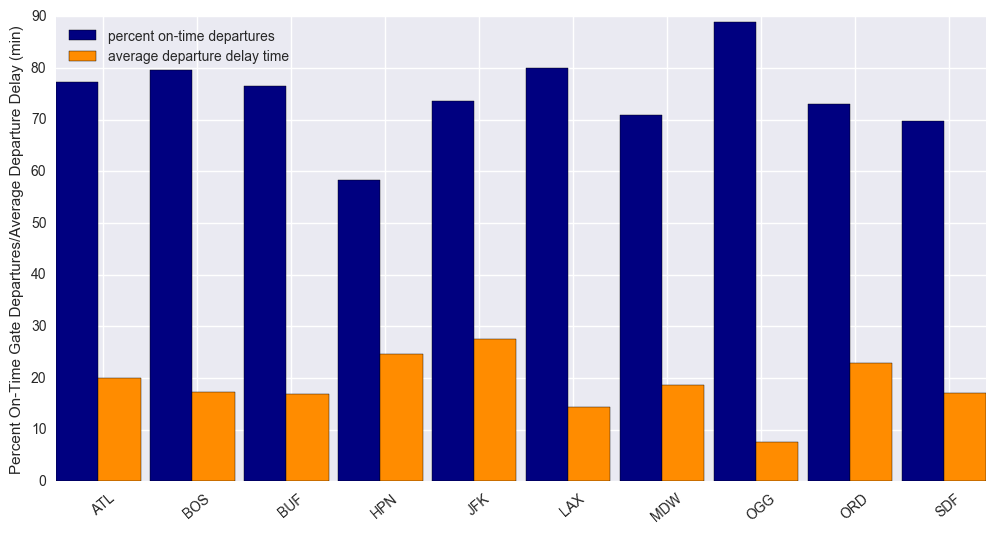

In [324]:
# plot on-time gate departures for select airports
mask = (data['airport'] == 'BOS')|(data['airport'] == 'ATL') |(data['airport'] == 'BUF')|(data['airport'] == 'HPN')|(data['airport'] == 'JFK')| (data['airport'] == 'ORD')| (data['airport'] == 'OGG')|(data['airport'] == 'MDW')|(data['airport'] == 'LAX')|(data['airport'] == 'SDF')
dept_data = data[mask].groupby(['airport'])['percent on-time gate departures'].mean()

plt.figure(figsize = (12,6))

dept_bar_positions = [i + 0.65 for i in range(len(dept_data))]
dept_bar_heights = dept_data.values * 100
# plot on-time departures
plt.bar(dept_bar_positions, dept_bar_heights, 0.45, color = "navy")
plt.xticks([i + 0.5 for i in dept_bar_positions], dept_data.index.values, rotation = 40)

# plot departure delays
delay_data = data[mask].groupby(['airport'])['average airport departure delay'].mean()
delay_bar_positions = [i + 1.1 for i in range(len(delay_data))]
delay_bar_heights = delay_data.values
plt.bar(delay_bar_positions, delay_bar_heights, 0.45, color = 'darkorange')

plt.ylabel('Percent On-Time Gate Departures/Average Departure Delay (min)')
plt.legend(labels = ['percent on-time departures', 'average departure delay time'], loc = 'best')
plt.show()

This graph contains the percent of on time departures and the average delay time for a few select airports of varying sizes and locations to demonstrate that there isn't necessarily a clear relationship between the two. The airports with the longest delay times are JFK, John F. Kennedy International Airport and HPN, the Westchester County Airport. Although they are both in the same Northeast region promixal to NYC, JFK is a busy international airport whereas HPN is serviced by only seven airlines with no international flights. Although both JFK and HPN have high average delay times, OGG (the Kahului Airport in Hawaii) has a very short 

In [211]:
X = data[[u'departures for metric computation', u'Departure Cancellations',
          u'Departure Diversions', u'percent on-time gate departures','percent on-time airport departures', 
       u'average_gate_departure_delay', u'average_taxi_out_time', u'average taxi out delay', 
          u'average airport departure delay', u'average airborne delay',  u'arrivals for metric computation', 
          u'Arrival Cancellations', u'Arrival Diversions', u'percent on-time gate arrivals', u'average taxi in delay',
       u'average block delay', u'average gate arrival delay']]

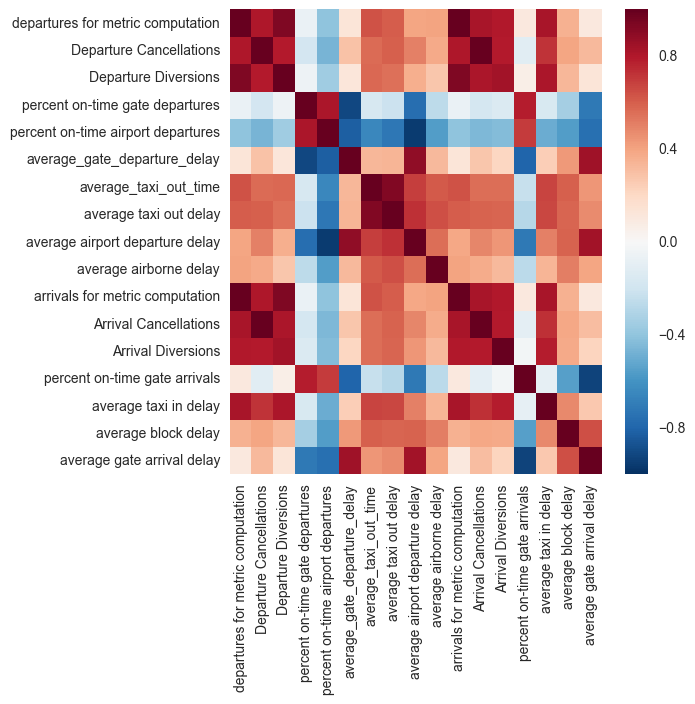

In [213]:
plt.figure(figsize = (6,6))
sns.heatmap(X.corr())
plt.show()

This heatmap is arranged with all departure-related features on its top and left halves and all arrival-related features on the bottom and right halves. The blue bands are percent on-time arrivals, departures, and gate departures, which are obviously negatively correlated with all delay metrics. In general, all delay features seem to be positively correlated with each other, there are a few specific observations to make. 

Average gate departure delays are strongly correlated with both average airport departure delays, as well as gate arrival delays. This makes sense, because if a plane is late leaving its gate, it will be behind schedule taking off, and an arriving plane can't pull into the gate until the first plane has left. In fact, average gate and aiport departure delays are more strongly correlated with average gate arrival delay than taxi-in delays.

There are strong correlations between total arrivals, total departures, and number of cancellations and diversions. This is all a consequence of simply having more flights coming and going to busy airports. However, there is one delay-related factor that seems to be correlated with all of these: taxi-in delay. Taxi-in delay is weakly correlated with percent on-time departures, so this may be a problem only at airports of a certain size.

These correlations point to delays originating with departing flights, as the effect of staying longer than anticipated at the gate makes the flight itself late to take off, but also prevents incoming flights from pulling into the gate at their scheduled times.

# Principal Component Analysis

In [214]:
# normalize the data and remove percent columns 
Xt = scale(X[[u'departures for metric computation', u'Departure Cancellations',
          u'Departure Diversions', u'average_gate_departure_delay', u'average_taxi_out_time', u'average taxi out delay', 
          u'average airport departure delay', u'average airborne delay',  u'arrivals for metric computation', 
          u'Arrival Cancellations', u'Arrival Diversions', u'average taxi in delay', u'average block delay', 
              u'average gate arrival delay']])

In [216]:
pca = PCA(n_components = 14)
pca = pca.fit(Xt)

In [284]:
# make dataframe of principal components
Y = pd.DataFrame(pca.fit_transform(Xt), columns = ['PC{}'.format(str(i)) for i in range(1,15)])
Y['region'] = data['FAA REGION']
Y['busy'] = [
    2 if x >= 300000 else 1 if (x < 300000 and x > 100000) else 0 for x in data['departures for metric computation']
]
Y['airport'] = data['airport']

In [218]:
exp_variances = np.cumsum(pca.explained_variance_ratio_*100)

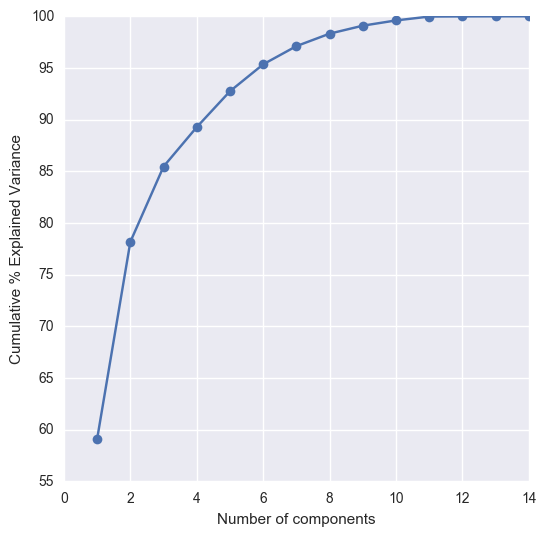

In [219]:
plt.figure(figsize = (6,6))
plt.plot(range(1, 15), exp_variances, '-o')
plt.xlabel("Number of components")
plt.ylabel("Cumulative % Explained Variance")
plt.show()

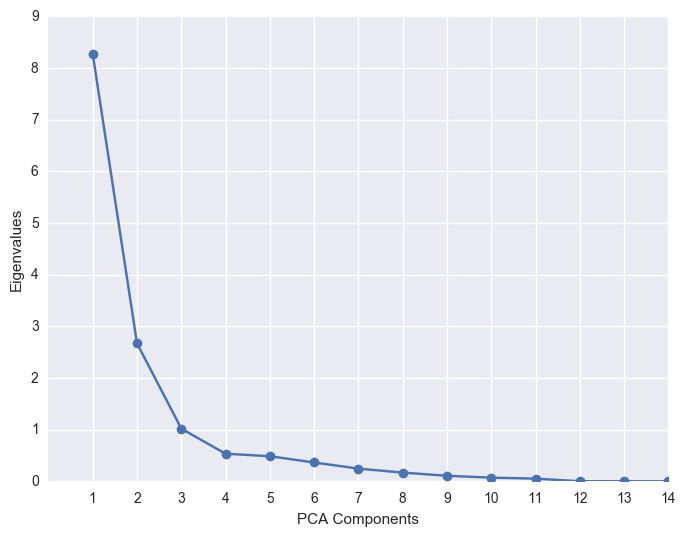

In [220]:
# scree plot of eigenvalues from pca.explained_variance
plt.figure(figsize = (8,6))
plt.plot(range(1,15), pca.explained_variance_, "-o")
plt.xticks(range(1,15))
plt.ylabel("Eigenvalues")
plt.xlabel("PCA Components")
plt.show()

From examining the cumulative explained variance curve as well as the eigenvalues plot, I will select the first three principle components, as these will account for approximately 85% of the variance in the data and this seems to be where an "elbow" occurs in the eigenvalue plot.

In [222]:
# eigenvectors are in pca.components_
eigenvectors = pd.DataFrame(pca.components_, columns = [u'departures for metric computation', u'Departure Cancellations',
          u'Departure Diversions', u'average_gate_departure_delay', u'average_taxi_out_time', u'average taxi out delay', 
          u'average airport departure delay', u'average airborne delay',  u'arrivals for metric computation', 
          u'Arrival Cancellations', u'Arrival Diversions', u'average taxi in delay', u'average block delay', 
              u'average gate arrival delay'])
eigenvectors.head(3)

,departures for metric computation,Departure Cancellations,Departure Diversions,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,arrivals for metric computation,Arrival Cancellations,Arrival Diversions,average taxi in delay,average block delay,average gate arrival delay
0,0.302891,0.302562,0.292481,0.158552,0.286629,0.288579,0.255493,0.203416,0.302640,0.302210,0.289626,0.299519,0.217245,0.173862
1,0.255345,0.138365,0.268606,-0.444343,-0.106630,-0.123655,-0.379182,-0.197965,0.256646,0.154566,0.182089,0.130730,-0.264484,-0.475898
2,-0.007805,0.234070,0.109756,0.432053,-0.394528,-0.372579,0.129877,-0.506134,-0.006141,0.234982,0.150449,0.017603,-0.188877,0.255056


**PC1:** The first principal component seems to be composed of the factors reflecting how busy an airport is. It weights number of departures, arrivals, diversions, and cancellations relatively equally, as well as factors related to taxiing. An airport high on PC1 likely has longer delays at any point in an airplane's journey.

**PC2:** The second principal component negatively weights departure, arrival, gate, and block delays, so an airport high on PC2 likely has shorter delays.

**PC3:** The third principal component negatively weights airborne delays and taxi out time and delays. An airport high in PC3 has longer airborne delays and takes longer to taxi to the runway.

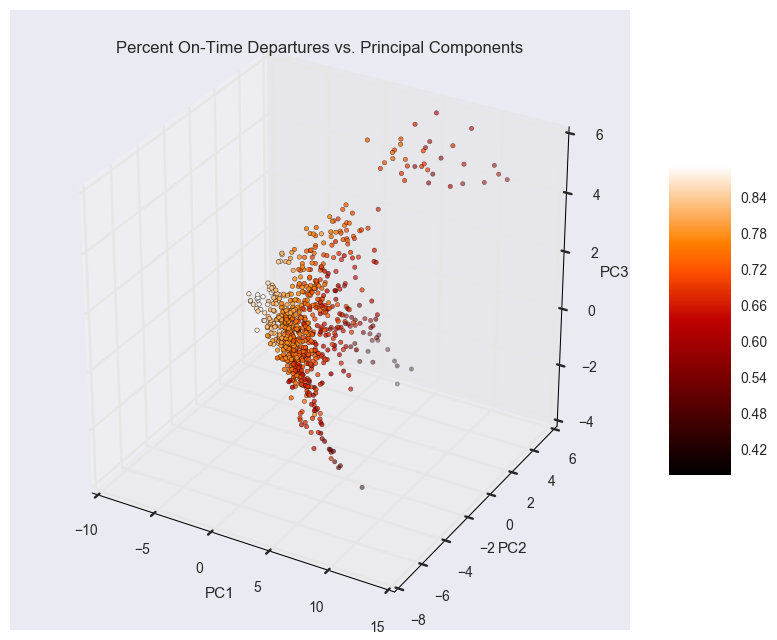

In [298]:
# plot against percent departure delays
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    Y['PC1'], Y['PC2'], Y['PC3'], 
    zdir='x', s = 10, c = X['percent on-time airport departures'], 
    cmap = 'gist_heat', depthshade=True)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Percent On-Time Departures vs. Principal Components")
fig.colorbar(p, shrink=0.5, aspect=5)
plt.show()

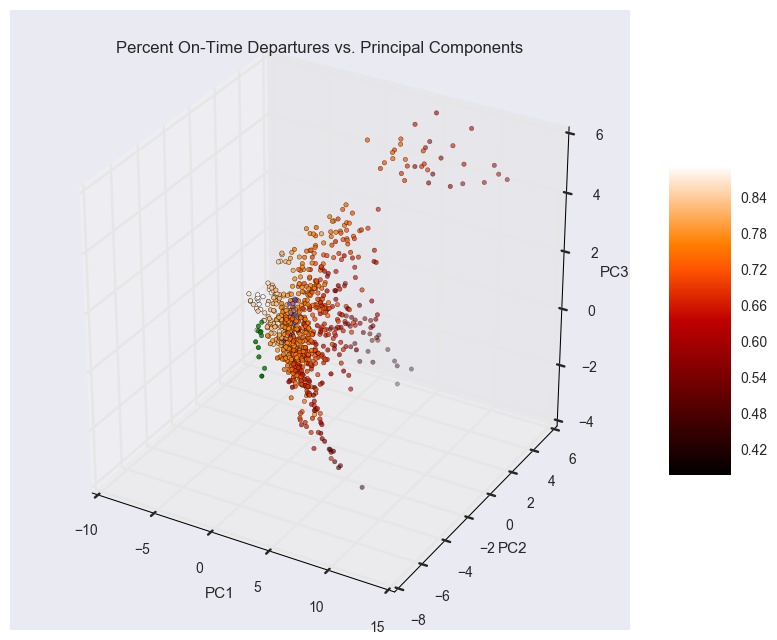

In [326]:
# Show 2 example airports
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    Y['PC1'], Y['PC2'], Y['PC3'], 
    zdir='x', s = 10, c = X['percent on-time airport departures'], 
    cmap = 'gist_heat', depthshade=True)

# make a mask for JFK and OGG and plot them in different colors
mask = ((Y['airport'] == 'HPN') | (Y['airport'] == 'OGG'))

color_dict = {'HPN':'green', 'OGG': 'blue'}
color_map = [color_dict[i] for i in Y[mask]['airport']]

ax.scatter(Y[mask]['PC1'], Y[mask]['PC2'], Y[mask]['PC3'], s = 10, c = color_map)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Percent On-Time Departures vs. Principal Components")
fig.colorbar(p, shrink=0.5, aspect=5)
plt.show()

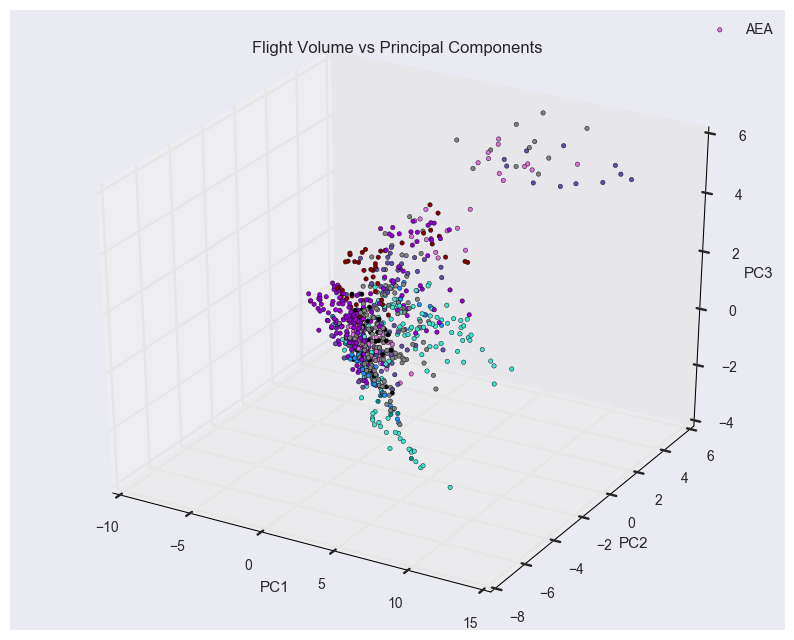

In [313]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

color_dict = {
    'ASW': u'orchid', 'AAL': u'darkcyan', 'ASO': u'grey', 'ANE': u'dodgerblue', 
    'AEA': u'turquoise', 'AWP': u'darkviolet', 'AGL': '#624ea7', 'ANM': 'maroon', 'ACE': 'k'
}
color_map = [color_dict[i] for i in Y['region']]
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y['PC1'], Y['PC2'], Y['PC3'], zdir='x', s = 10, c=color_map, depthshade=False)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Flight Volume vs Principal Components")
ax.legend(labels = color_dict.keys())
plt.show()

This plot of 

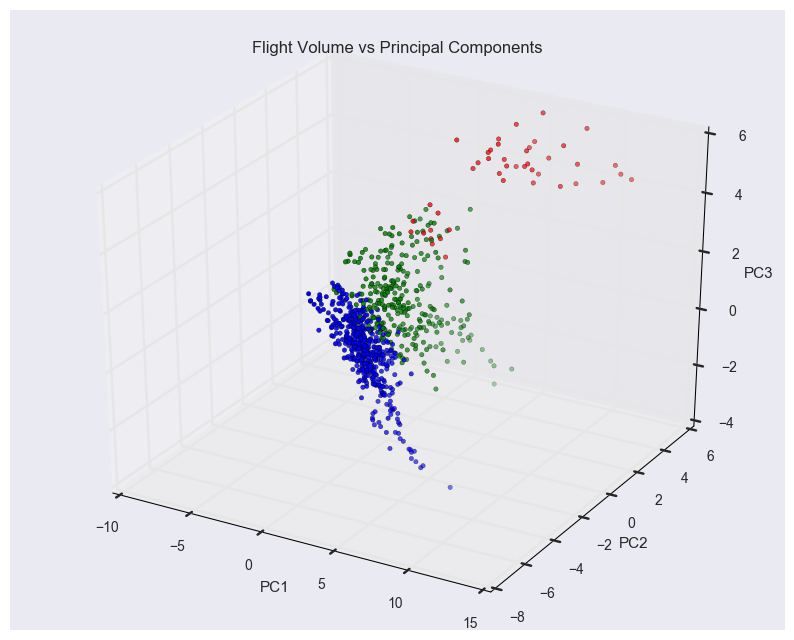

In [280]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

color_dict = {0:'blue', 1: 'green', 2: 'red'}
color_map = [color_dict[i] for i in Y['busy']]
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y['PC1'], Y['PC2'], Y['PC3'], zdir='x', s = 10, c=color_map, depthshade=True)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Flight Volume vs Principal Components")
plt.show()

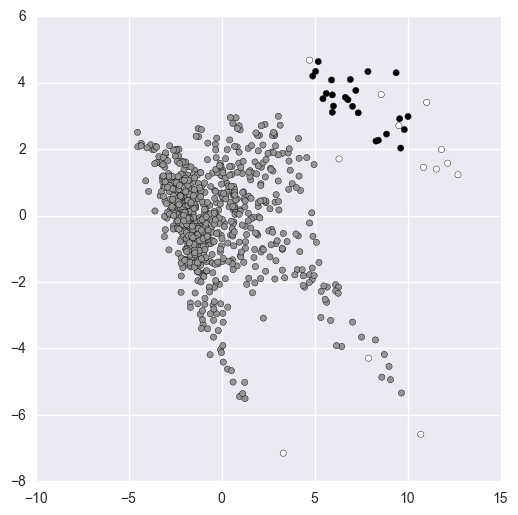

Silhouette score:  0.587743805013


In [283]:
# try dbscan to find best clusters
Y_cluster = Y[[u'PC1', u'PC2', u'PC3', u'PC4', u'PC5', u'PC6', u'PC7', u'PC8', u'PC9',
       u'PC10', u'PC11', u'PC12', u'PC13', u'PC14']]
db = DBSCAN(eps = 3, min_samples = 5)
db.fit(Y_cluster)
labels = db.labels_

fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(Y_cluster['PC1'], Y_cluster['PC2'], c = labels)
plt.show()

print "Silhouette score: ", silhouette_score(Y_cluster[['PC1','PC2']], labels, metric = 'euclidean')